# OpenCVの画像編集を組み合わせて特徴を検出する

In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider
print(cv2.__version__)

# jupyter notebookの場合はmatplotlibのインライン表示を有効にする
%matplotlib inline

4.11.0


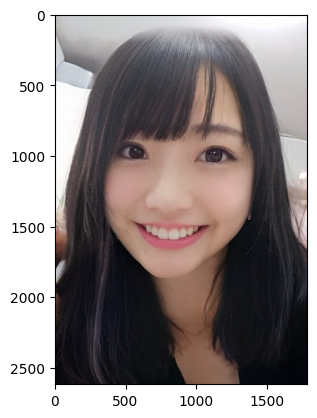

In [4]:
img = cv2.imread("./shining.jpg")

# GBRの順番になっているので、matplotlibで表示するためにはRGBの順番にする必要がある
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

### A 基本形
照度のばらつきや微細な模様の強調
1. グレースケール変換
2. CLAHE（コントラスト補正）
3. ガウシアンブラー（軽度なノイズ除去）
4. サイズ統一（リサイズ＆中心トリミング）
5. 正規化（0〜1スケーリング）

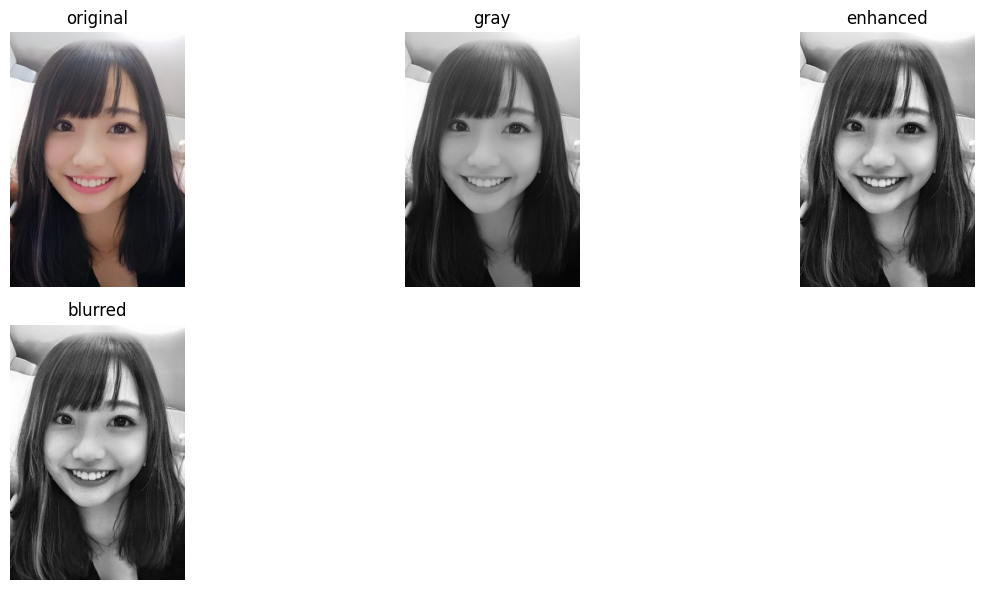

In [5]:
steps = {}
steps["original"] = img

# 2. グレースケール変換
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
steps["gray"] = gray

# 3. CLAHEでコントラスト補正
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced = clahe.apply(gray)
steps["enhanced"] = enhanced

# 4. ガウシアンブラーで軽度なノイズ除去
blurred = cv2.GaussianBlur(enhanced, (3, 3), 0)
steps["blurred"] = blurred

plt.figure(figsize=(12, 6))
for i, (key, val) in enumerate(steps.items()):
    plt.subplot(2, 3, i+1)
    if key == 'original':
        plt.imshow(cv2.cvtColor(val, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(val, cmap='gray')
    plt.title(key)
    plt.axis('off')
plt.tight_layout()
plt.show()

### 境界検出強化型（セグメンテーション向け）
物体同士の境目を強調(Canny or Sobel)
1. グレースケール変換
2. Sobel/Laplacianフィルターでエッジ強調
3. エッジ画像と元画像のチャンネル連結（= 3ch→4chにする）
4. リサイズ＆正規化


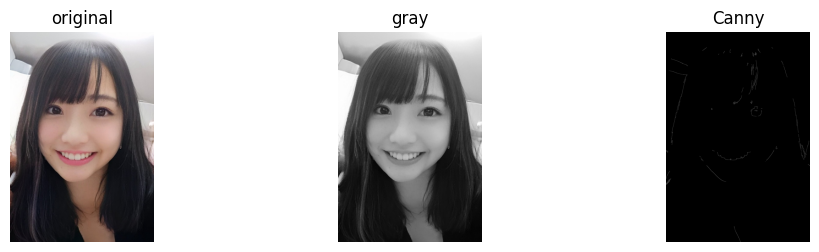

In [6]:
EDGE_DETECTION = "Canny"
steps = {}
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

steps["original"] = img_rgb

# 3. グレースケール変換（エッジ検出のため）
gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
steps["gray"] = gray


if EDGE_DETECTION == "Canny":
    # 4. Cannyエッジ検出
    edge = cv2.Canny(gray, threshold1=50, threshold2=150)
    steps["Canny"] = edge
else:
    # 4. Sobelフィルタでエッジ検出（x方向＋y方向の合成）
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel_mag = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    edge = np.uint8(255 * sobel_mag / np.max(sobel_mag))  # 0〜255スケーリング
    steps["sobel_mag"] = edge

# 5. エッジ画像を追加チャンネルとして連結（RGB + Edge → 4ch）
# edge_channel = np.expand_dims(edge, axis=-1)
# input_4ch = np.concatenate((resized, edge_channel), axis=-1)

# 6. 画像を表示
plt.figure(figsize=(12, 6))
for i, (key, val) in enumerate(steps.items()):
    plt.subplot(2, 3, i+1)
    if key == 'original':
        plt.imshow(val)
    else:
        plt.imshow(val, cmap='gray')
    plt.title(key)
    plt.axis('off')


ごちゃごちゃな背景を削ぎ落としたい

メインの物体：平坦・単調・エッジが少ない

背景：物体やテクスチャでエッジが多い

→ エッジの“なさ”を手がかりにメインの物体を推定できる

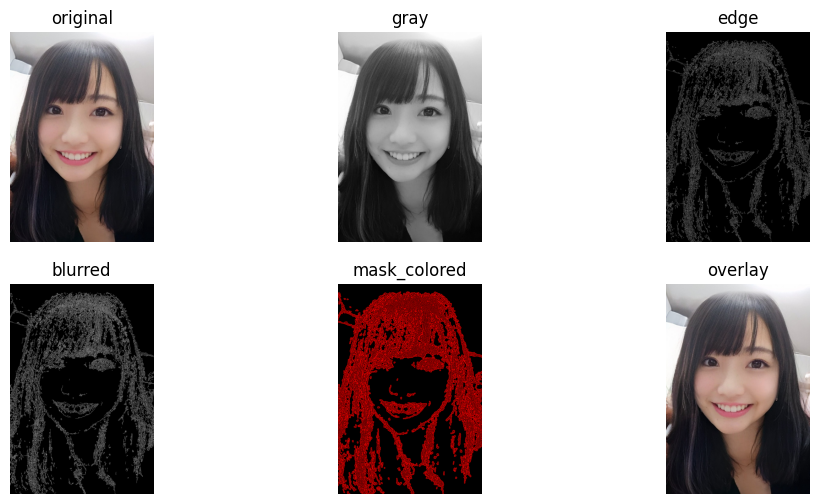

In [ ]:
steps = {}
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
steps["original"] = img_rgb

# 2. グレースケール変換
gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
steps["gray"] = gray

# 3. Cannyエッジ検出（ヒステリシスしきい値は調整可能）
# edge = cv2.Canny(gray, threshold1=50, threshold2=150)
edge = cv2.Canny(gray, threshold1=0, threshold2=26)
steps["edge"] = edge

# 4. 平滑化（ノイズ除去）
blurred = cv2.GaussianBlur(edge, (5, 5), 0)
steps["blurred"] = blurred

# 5. エッジの少ない領域を抽出（反転して白）
# _, mask = cv2.threshold(blurred, 120, 255, cv2.THRESH_BINARY_INV) # 手動でしきい値指定
# _, mask = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU) # 自動でしきい値指定(Otsu)
mask = cv2.adaptiveThreshold(
    blurred, 255,
    cv2.ADAPTIVE_THRESH_MEAN_C,  # または cv2.ADAPTIVE_THRESH_GAUSSIAN_C
    cv2.THRESH_BINARY_INV,
    blockSize=11,  # 奇数（例：11, 15, 21）に調整可
    C=2            # 微調整用オフセット値（±数値）
)  # 自動でしきい値指定(adaptive) 局所領域ごとにしきい値を変える

# マスクに色を塗る
mask_colored = np.zeros_like(img_rgb)
mask_colored[:, :] = [255, 0, 0]  # 赤色
mask_colored = cv2.bitwise_and(mask_colored, mask_colored, mask=mask)
steps["mask_colored"] = mask_colored

# 6. マスクを元画像の上に重ねる
alpha = 0.4
overlay = cv2.addWeighted(img_rgb, 1.0, mask_colored, alpha, 0)
steps["overlay"] = overlay

# 7. 画像を表示
plt.figure(figsize=(12, 6))
for i, (key, val) in enumerate(steps.items()):
    plt.subplot(2, 3, i+1)
    if key == 'original':
        plt.imshow(val)
    else:
        plt.imshow(val, cmap='gray')
    plt.title(key)
    plt.axis('off')